In [1]:
#from numpy import ndarray,array, transpose
from neurotron.neurotron import Monitor
from neurotron import Attribute, Matrix, Field, Collab, Excite, Predict, Terminal
from neurotron import isa,rand,sum,zeros,ones,row,column,min,max,seed, AND, OR, NOT, all


In [2]:
shape = (3,9,2,5)
collab=Terminal(Collab(*shape))
v = zeros(1,3*9);v[0] = v[1] = 1;v
collab(v)

[1 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 0]

In [3]:
#===========================================================================================
# tokenizer
#===========================================================================================


token = {'Mary': [1,0,0,0,0,0,0,1,1],
         'John': [0,1,0,0,0,0,0,1,1],
         'likes':[0,0,1,0,0,0,0,1,1],
         'to':   [0,0,0,1,0,0,0,1,1],
         'sing': [0,0,0,0,1,0,0,1,1],
         'dance':[0,0,0,0,0,1,0,1,1],
         '.':    [0,0,0,0,0,0,1,1,1],
        }


In [10]:
#=========================================================================
# class Token
#=========================================================================

class Token(dict):
    def __init__(self,arg=None):
        self.dict = arg if arg is not None else {}
    def __getitem__(self,key):
        return self.dict[key]
        
#=========================================================================
# class Out
#=========================================================================

class Out:
    def __init__(self,cluster,i,j,tag):
        self.cluster = cluster
        self.i = i
        self.j = j
        self.tag = tag

    def out(self):
        data = self.cluster.get(self.tag)
        return data[self.i,self.j]

#=========================================================================
# class Cell
#=========================================================================

class Cell(Attribute):
    def __init__(self,cluster,i,j):
        """
        class Cell: access state attributes of cells[i,j]
        >>> cell = Cell(Cells(),1,1)
        >>> cell.u = 1
        """
        tags = ['u','q','d','b','x','y','s','l']
        for tag in tags:
            self.set(tag,Out(cluster,i,j,tag.upper()))
        self.predict = None

    def state(self):
        tags = ['b','d','l','q','s','u','x','y']
        dict = {}
        for tag in tags:
            dict[tag] = self.get(tag).out()
        return dict

#=========================================================================
# class Cluster
#=========================================================================

class Cluster(Attribute):
    verbose = 0
    def __init__(self,m=4,n=10,d=2,s=5,f=None):
        if f is None: f = n
        self.shape = (m,n,d,s)
        self.sizes = (f,n*m)               # (M,N)
        self.cdx = Matrix(range(m*n))      # access context vector
        self.fdx = m*n+Matrix(range(f))    # access feedforward vector
        self.k = Matrix(range(n*m))

        self._excite = Terminal(m,n)       # simple excite terminal
        self._collab = Terminal(Collab(m,n,d,s))
        self._predict = Terminal(Predict(m,n,d,s,rand=True))
        
        self.U = Matrix(m,n)
        self.Q = Matrix(m,n)
        self.D = Matrix(m,n)
        self.B = Matrix(m,n)
        self.X = Matrix(m,n)
        self.Y = Matrix(m,n)
        self.S = Matrix(m,n)
        self.L = Matrix(m,n)

    def range(self):
        return range(self.sizes[1])

    def zero(self):
        return Matrix(*self.shape[:2])
        
    def split(self,y):    # split y int context c and feedforward f
        """
        >>> cells = Cluster(3,4,2,5,7)
        >>> y = row([1,1,1,0,0,0,1,1,1,0,0,0],[1,0,1,0,1,0,1])
        >>> cells.split(y)
        ([1 1 1 0 0 0 1 1 1 0 0 0],[1 0 1 0 1 0 1])
        """
        return (y[self.cdx],y[self.fdx])
        
    def kappa(self,i,j=None):
        """
        self.kappa():  convert matrix indices to linear index or vice versa
        >>> o = Cluster(m=4,n=10)
        >>> k = o.kappa(i:=1,j:=3)  # k = i+j*m 
        13
        >>> ij = o.kappa(k:=13)    # i = k%m, j = k//m
        (1,3)
        """

        m,n,d,s = self.shape
        if j is None:
            k = i
            return (k%m,k//m)
        else:
            return i + j*m

    def state(self,i,j):
        tags = ['B','D','L','Q','S','U','X','Y']
        s = Matrix(1,len(tags))
        for k in range(len(tags)):
            s[k] = self.get(tags[k])[i,j]
        return s

    def smap(self,label=''):
        m,n,d,s = self.shape
        S = Field(m,n,1,8)
        for k in range(m*n):
            S[k] = self.state(*self.kappa(k))
        S.smap(label)

    def map(self):
        self.K.imap('K: ')     # Map(self).Kmap()
        self.P.vmap('P: ')

    def update(self,y):        # update y
        y[self.k] = self.Y
        return y
        
    def stimu(self,y):
        c,f = self.split(y)
        self.U = self._excite(f)
        return y

    def react(self,y):
        self.Y = self.U * self.X
        self.L = self.X * self.Y
        for k in self.range():
            if self.L[k]:
                _Pij = self._predict.P[k]
                self._predict.P[k] += self._predict.I[k]
                self._predict.P[k] = max(0,min(self._predict.P[k],1))
                if self.verbose > 0:
                    print('learn P[%g]:' % k,_Pij,'=>',self.P[k])
        #print('##### react y:',y,y.shape)
        y[self.k] = self.Y
        #print('##### react y:',y,y.shape)
        return y

    def depress(self,y):
        c,f = self.split(y)
        self.D = self._collab(c)
        self.L = self.zero()
        return y

    def excite(self,y):
        self.Q = self.U.copy() 
        return y

    def burst(self,y):
        self.B = AND(NOT(self.D),self.Q)
        self.Y = OR(self.Y,self.B)
        return self.update(y)

    def predict(self,y):
        c,f = self.split(y)
        self.S = self._predict(c)
        self.X = self.S
        for k in self.range():
            if self.S[k]: print('#### I[%g]:'%k,self._predict.I[k])
        return y

    def relax(self,y):
        M,N = self.sizes
        m,n,d,s = self.shape
        c = y[:N];  f = y[N:N+M]; Z = self.zero()
        self.set('U,Q,D,B,Y,S',(Z,Z,Z,Z,Z,Z))
        return self.update(y)

    def clear(self,M):
        m,n,d,s = self.shape
        M = Matrix(m,n)
        
    def idle(self):
        clear(self.B);  clear(self.D);  clear(self.L);  clear(self.Q)
        clear(self.S);  clear(self.U);  clear(self.X);  clear(self.Y)
        for k in range(self.sizes[1]):
            y[k] = self.Y[k]
        return y

    def plot(self,mon,subplot=0,title=None):
        m,n,d,s = self.shape
        for i in range(m):
            for j in range(n):
                cell = Cell(self,i,j)
                mon(cell,i+subplot*(m+1),j)
        if title is not None:
            mon.title(title)

    def apply(self,y,tag='',log=None,all=None):
        m,n,d,s = self.shape
        y = self.stimu(y);
        prefix = tag + ' - ' if tag != '' else ''
        if log is not None:
            print('stimu ...');  self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'stimu')

        y = self.react(y);
        if log is not None:
            print('ract ...');  self.smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'react')
        else:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'react')
        
        y = cells.depress(y);
        if log is not None:
            print('depress ...');  self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'depress')
        
        y = cells.excite(y);
        if log is not None:
            print('excite ...');   self.smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'excite')

        y = cells.burst(y);
        if log is not None:
            print('burst ...');    self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'burst')
        
        y = cells.predict(y);  
        if log is not None:
            print('predict ...');  self.smap()
        if all is not None:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        else:
            cells.plot(mon,1);  mon.xlabel(n/2-0.5,prefix+'predict')
        
        y = cells.relax(y);
        if log is not None:
            print('relax ...');    self.smap()
        if all is not None:
            mon = Monitor(2*m+1,n); 
            cells.plot(mon,0);  mon.title(prefix+'relax')
        return y        

#===============================================================================================
# tokenizer
#===============================================================================================


token = Token({'Mary': [1,0,0,0,0,0,0,1,1],
               'John': [0,1,0,0,0,0,0,1,1],
               'likes':[0,0,1,0,0,0,0,1,1],
               'to':   [0,0,0,1,0,0,0,1,1],
               'sing': [0,0,0,0,1,0,0,1,1],
               'dance':[0,0,0,0,0,1,0,1,1],
               '.':    [0,0,0,0,0,0,1,1,1],
               })


#### I[11]: [0.1 0.1 -0.1 0.1 -0.1; 0 0 0 0 0]


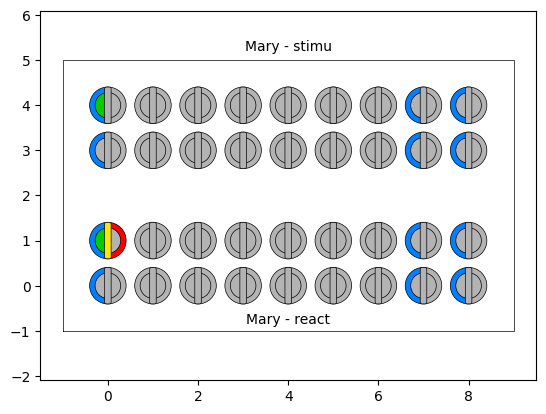

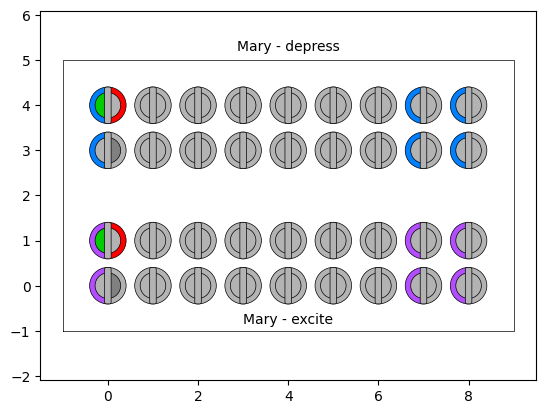

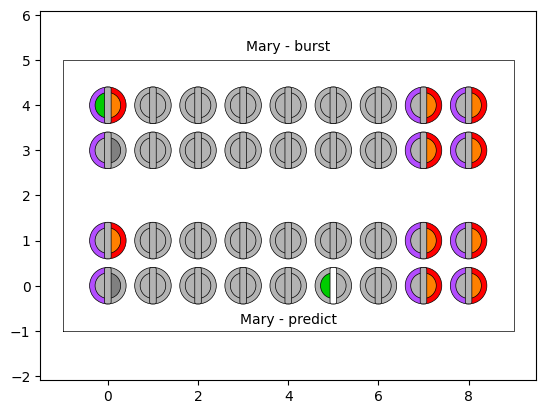

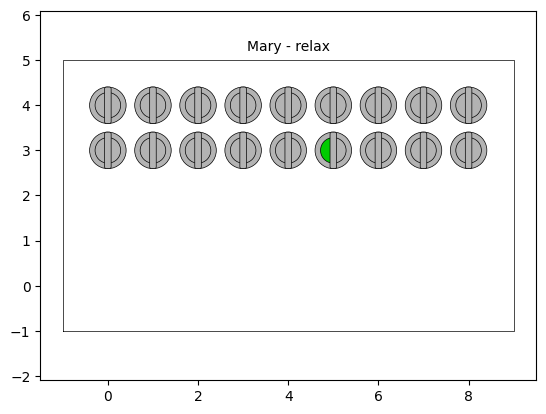

In [11]:
shape = (2,9,2,5); m,n,d,s = shape
seed(1);  cells = Cluster(*shape)

cells.X[0] = 1
y = row(zeros(1,m*n),token['Mary'])
y = cells.apply(y,'Mary',all=True)